<a href="https://colab.research.google.com/github/Zaidanebreak/Classification-Model-for-ATLAS-Higgs-Boson-Machine-Learning-Challenge-2014/blob/main/BDT_on_HEP_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BDT model to Classify events to (Signal vs. Background) 

## BDT (Boosted Decision Trees) model for Dataset from the ATLAS Higgs Boson Machine Learning Challenge 2014: 

http://opendata.cern.ch/record/328 



The Below commands where implemented and taken from the following two tutorials written by Prof. David Rousseau but applied on a different dataset: 

1) https://github.com/dhrou/HEPMLtutorials/blob/master/HEPML_HandsOn_BDT.ipynb \
2) https://github.com/dhrou/HEPMLtutorials/blob/master/HEPML_HandsOn_BDT_addendum.ipynb

### In this Notebook we will replace the extreme values with the mean value of each feature excluding the extreme values.

$ \bar{x}_{feature} \; = \; \dfrac{\sum{x_{feature}}}{\text{number of rows} \; - \; \text{number of extreme values for each feature}}$

The Extreme value is basically when the number of jet is 0 or 1 some features will have no value so instead of writing NaN, our Dataset will have $-999.$ 

Our data has Primitive features and Derived features, our goal is to investigate how good the classifier will turn to be:

1)The case of Derived features alone \
2)The case of premitive features alone \
3)The case of both derived and premitive together



#### ROC & AUC & Significance will be used to evaluate the model but the main critaria to tell how good is our model will be: Significance.

### Importing Libraries:

In [1]:
import os    #provides functions for interacting with the operating system.
import numpy as np #provides a large set of numeric datatypes that you can use to construct arrays
import pandas as pd #work with dataframes 
import matplotlib.pyplot as plt #manipulate elements of a figure, such as creating a figure, creating a plotting area, plotting lines, adding plot labels, etc
from IPython.display import display, HTML 
import time 
np.random.seed(10) #to make the np.random yields the same result when used again. 

### Loading the two models 

In [2]:
!pip install xgboost --upgrade
pass
import xgboost #XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
import lightgbm #LightGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage and it is a fast processing algorithm.
print("xgboost Version is: " + xgboost.__version__)
print("lightgbm Version is: " + lightgbm.__version__)

xgboost Version is: 1.4.2
lightgbm Version is: 2.2.3


Find here the documentation for each Algorithm:

1) https://xgboost.readthedocs.io/en/latest/ \
2) https://lightgbm.readthedocs.io/en/latest/

xgboost is Basically the model we will concentrate on (i.e.: BDT) where lightgbm is another good fast model, we will perform some comparisons between those two models to our Dataset 

### Linking your Google Colab with Google drive.

The folowing code will bw used to connect your google drive with google colab, after running these codes a link will appear which will direct you to a page where you select the google account you are willing to access and a code will appear which you will need to copy and paste in the box appears below the Link

In [3]:
!pip install PyDrive
import os 
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

# Here a link will appear you press on it, it will direct you to a page where you select the google account and copy the key and paste it in the required box.

### Load the Dataset from Drive

In [4]:
download = drive.CreateFile({'id':'1hDw0S2idRsymTYDiDJkr0LYt-MOH_cFo'})  # here you juat take the ID part of the shared link file from google drive
download.GetContentFile("atlas-higgs-challenge-2014-v2.csv")  # Write the name of the file as in Google Drive

datapath=''
!ls -lrt
filename=os.path.join(datapath, "atlas-higgs-challenge-2014-v2.csv")   # the name of the file 
dfall = pd.read_csv(filename)   # Let python read the dataset
dfall = dfall.sample(frac=1).reset_index(drop=True) # to return a sample of the dataframe and reset the index if exists in the dataframe.
from datetime import datetime 
print("now:", datetime.now())
print("File loaded with", dfall.shape[0],"events ")   # dfall.shape gives the dimension of the dataframe and with [0] gives the first  dim. which is the number of rows. 

total 191736
drwxr-xr-x 1 root root      4096 Jul 16 13:20 sample_data
-rw-r--r-- 1 root root       720 Aug  5 07:40 adc.json
-rw-r--r-- 1 root root    443741 Aug  5 08:35 XGBoost.model
-rw-r--r-- 1 root root    269988 Aug  5 08:42 LightGBM.model
-rw-r--r-- 1 root root     15471 Aug  5 08:42 Significance_comparing.pdf
-rw-r--r-- 1 root root     48442 Aug  5 08:42 myxgb.dat
-rw-r--r-- 1 root root 195543089 Aug  5 10:16 atlas-higgs-challenge-2014-v2.csv
now: 2021-08-05 10:16:35.490266
File loaded with 818238 events 


### Extract the features in the Dataset

In [5]:
for i in dfall.columns:
  print(i)

EventId
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis
DER_pt_h
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_deltar_tau_lep
DER_pt_tot
DER_sum_pt
DER_pt_ratio_lep_tau
DER_met_phi_centrality
DER_lep_eta_centrality
PRI_tau_pt
PRI_tau_eta
PRI_tau_phi
PRI_lep_pt
PRI_lep_eta
PRI_lep_phi
PRI_met
PRI_met_phi
PRI_met_sumet
PRI_jet_num
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi
PRI_jet_all_pt
Weight
Label
KaggleSet
KaggleWeight


### Visualize the First few events in the Dataframe

In [6]:
dfall.head(10)   # to show the first 10 rows in the Dataframe

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,238233,110.776,9.816,60.117,163.255,5.209,1131.346,-6.148,1.436,13.178,270.273,1.470,1.129,1.000,37.582,0.684,-0.202,55.256,0.851,-1.628,95.581,-1.493,311.727,2,117.365,-1.808,2.008,60.070,3.401,1.213,177.435,0.000461,s,t,0.001503
1,303463,89.278,32.006,68.869,0.245,-999.000,-999.000,-999.000,2.869,0.245,64.833,1.036,-1.414,-999.000,31.836,-1.502,1.450,32.996,-0.710,-1.308,12.197,3.128,105.755,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0.005721,s,t,0.018636
2,749924,107.597,69.753,72.959,18.621,-999.000,-999.000,-999.000,2.877,18.621,72.634,1.661,0.925,-999.000,27.297,-1.539,-1.578,45.336,-2.169,1.898,27.494,-1.556,171.780,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0.512740,b,v,0.932279
3,660576,123.369,31.600,80.724,23.200,-999.000,-999.000,-999.000,3.024,23.200,83.809,0.545,-1.413,-999.000,54.239,2.041,0.330,29.570,2.322,-2.681,33.035,2.542,127.435,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0.005721,s,v,0.010415
4,789596,121.775,16.688,64.226,49.821,5.352,605.681,-7.124,2.913,21.609,147.900,0.867,-1.290,0.736,33.985,2.098,-1.476,29.466,1.671,1.405,55.980,1.819,224.669,2,49.049,2.865,-2.502,35.399,-2.486,-0.819,84.448,0.000461,s,v,0.000840
5,794695,134.873,21.307,103.008,3.320,-999.000,-999.000,-999.000,3.008,3.320,97.092,0.913,-1.409,-999.000,50.746,-0.057,-1.410,46.345,0.675,1.508,9.939,2.547,191.740,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000,0.005721,s,v,0.010415
6,428266,131.575,60.390,78.057,33.655,-999.000,-999.000,-999.000,2.925,0.136,93.455,1.618,0.853,-999.000,22.890,1.432,-0.114,37.025,-0.287,2.252,27.778,-0.202,68.171,1,33.540,0.537,-2.482,-999.000,-999.000,-999.000,33.540,0.781257,b,v,1.420504
7,176090,110.088,80.266,90.158,93.383,4.263,604.216,-4.107,2.170,61.488,270.717,4.470,-1.252,0.999,22.023,-0.244,2.475,98.437,0.731,-1.869,34.554,-0.351,326.771,2,95.870,-1.471,1.351,54.388,2.792,0.376,150.257,0.000461,s,t,0.001503
8,387409,118.750,15.571,66.570,248.515,0.129,90.649,0.412,1.020,0.152,395.182,1.809,1.381,0.000,47.075,-0.681,-0.596,85.149,0.258,-0.995,118.700,-0.840,339.106,2,137.978,-0.580,1.978,124.980,-0.710,2.645,262.957,0.000814,s,v,0.001483
9,600315,184.582,143.952,131.880,40.892,-999.000,-999.000,-999.000,2.859,40.892,134.510,1.467,-0.895,-999.000,54.515,1.318,1.705,79.995,1.045,-1.732,64.773,1.436,178.895,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000,0.000814,s,b,0.006690


### Get some Info and Describtions about the Dataset 

In [7]:
dfall.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,KaggleWeight
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,509118.500000,-48.819019,49.252714,81.140561,57.849524,-707.740880,-600.191191,-708.681306,2.373871,18.969617,158.596159,1.438776,-0.127277,-708.306918,38.698152,-0.011663,-0.013158,46.692414,-0.019079,0.049460,41.654526,-0.008634,209.908730,0.979923,-348.757840,-399.693294,-399.703858,-691.626111,-708.442206,-708.443312,73.205594,0.503144,2.012577
std,236205.109119,406.118397,35.378609,40.582708,63.411938,454.793899,658.724040,453.328599,0.780875,21.918491,116.089809,0.845109,1.194235,453.909127,22.429016,1.213511,1.816083,22.142337,1.264250,1.815099,32.496113,1.812703,126.816686,0.978793,533.097006,489.428560,489.420013,480.274744,453.699150,453.697158,98.331754,0.572200,5.439641
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,46.103000,0.047000,-1.414000,-999.000000,20.000000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.051000,-3.142000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000461,0.000839
25%,304559.250000,78.166000,19.304000,59.414000,14.164250,-999.000000,-999.000000,-999.000000,1.814000,2.839000,77.492000,0.885000,-1.371000,-999.000000,24.586000,-0.926000,-1.584000,32.375000,-1.012000,-1.513000,21.383000,-1.574000,122.985000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.005721,0.010415
50%,509118.500000,105.061000,46.484000,73.744000,38.470000,-999.000000,-999.000000,-999.000000,2.492000,12.383000,120.665000,1.281000,-0.356000,-999.000000,31.776000,-0.022000,-0.039000,40.543000,-0.040000,0.093000,34.768000,-0.019000,179.883000,1.000000,38.965000,-1.865000,-2.105000,-999.000000,-999.000000,-999.000000,40.506000,0.357223,0.806562
75%,713677.750000,130.730000,73.620000,92.188000,79.226750,0.499000,84.031750,-4.548000,2.962000,27.634000,200.884500,1.778000,1.228750,0.000000,44.919750,0.899000,1.559000,53.379000,0.957000,1.618000,51.912000,1.559000,263.828000,2.000000,75.470750,0.432000,0.489000,33.800000,-2.436000,-2.265000,110.387000,0.733462,2.360271
max,918237.000000,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,2079.162000,32.228000,1.414000,1.000000,764.408000,2.500000,3.142000,701.328000,2.506000,3.142000,2842.617000,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000,2.386316,106.908407


Notice the minimum value for some features is $-999.0$ which needs to be replaced in this notebook.

In [8]:
dfall.describe(include=['object'])   #to get describtion for Categorical Data

,Label,KaggleSet
count,818238,818238
unique,2,4
top,b,v
freq,538678,450000


In [9]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 818238 entries, 0 to 818237
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      818238 non-null  int64  
 1   DER_mass_MMC                 818238 non-null  float64
 2   DER_mass_transverse_met_lep  818238 non-null  float64
 3   DER_mass_vis                 818238 non-null  float64
 4   DER_pt_h                     818238 non-null  float64
 5   DER_deltaeta_jet_jet         818238 non-null  float64
 6   DER_mass_jet_jet             818238 non-null  float64
 7   DER_prodeta_jet_jet          818238 non-null  float64
 8   DER_deltar_tau_lep           818238 non-null  float64
 9   DER_pt_tot                   818238 non-null  float64
 10  DER_sum_pt                   818238 non-null  float64
 11  DER_pt_ratio_lep_tau         818238 non-null  float64
 12  DER_met_phi_centrality       818238 non-null  float64
 13 

As noticed from the Describtion some values has -999.000 which is an extreme value or in other words (NaN value) we will clean the data and replace it with the mean value for each feature.

### Finding the featrues which have Extreme Value

In [10]:
dfall_numeric = dfall.drop(columns = ['Label','KaggleSet'])
Extreme_features = []
print("The features which have the Extreme Value are:")
for i in dfall_numeric.columns:
  if dfall_numeric[dfall_numeric <-950][i] in dfall_numeric[i].values:
    print(i)
    Extreme_features.append(i)


The features which have the Extreme Value are:
DER_mass_MMC
DER_deltaeta_jet_jet
DER_mass_jet_jet
DER_prodeta_jet_jet
DER_lep_eta_centrality
PRI_jet_leading_pt
PRI_jet_leading_eta
PRI_jet_leading_phi
PRI_jet_subleading_pt
PRI_jet_subleading_eta
PRI_jet_subleading_phi


### Number of Occurence of the Extreme Value in each Feature

In [11]:
dfall_numeric.where(dfall_numeric < -950).count()

EventId                             0
DER_mass_MMC                   124602
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           580253
DER_mass_jet_jet               580253
DER_prodeta_jet_jet            580253
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         580253
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt             327371
PRI_jet_leading_eta            327371
PRI_jet_lead

### Figuring out the exact value of each extreme value in the dataset

Here any value less than  $-950$  will be treated as extreme value.

In [12]:
print("The Extreme Values in the dataset are:")
outliers = []
for i in Extreme_features:
  for j in range(dfall.shape[0]):
    if dfall[i][j] < -950:
      outliers.append(dfall[i][j])
np.unique(outliers)

The Extreme Values in the dataset are:


array([-999.])

### Replace each extreme value with the mean for each feature

The mean is for all the values in each feature excluding the extreme value.

In [13]:
for i in Extreme_features:
  dfall[i] = dfall[i].replace({-999.:dfall[dfall[i] > -900][i].mean()})  


In [14]:
dfall.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,KaggleWeight
count,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000,818238.000000
mean,509118.500000,121.867697,49.252714,81.140561,57.849524,2.404626,372.181050,-0.828740,2.373871,18.969617,158.596159,1.438776,-0.127277,0.458480,38.698152,-0.011663,-0.013158,46.692414,-0.019079,0.049460,41.654526,-0.008634,209.908730,0.979923,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.010470,73.205594,0.503144,2.012577
std,236205.109119,52.427890,35.378609,40.582708,63.411938,0.939764,214.770277,1.932744,0.780875,21.918491,116.089809,0.845109,1.194235,0.214722,22.429016,1.213511,1.816083,22.142337,1.264250,1.815099,32.496113,1.812703,126.816686,0.978793,46.975278,1.378225,1.406065,17.503390,1.095703,0.979395,98.331754,0.572200,5.439641
min,100000.000000,9.044000,0.000000,6.329000,0.000000,0.000000,13.602000,-19.012000,0.208000,0.000000,46.103000,0.047000,-1.414000,0.000000,20.000000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.051000,-3.142000,13.678000,0.000000,30.000000,-4.500000,-3.142000,30.000000,-4.500000,-3.142000,0.000000,0.000461,0.000839
25%,304559.250000,95.656000,19.304000,59.414000,14.164250,2.404626,372.181050,-0.828740,1.814000,2.839000,77.492000,0.885000,-1.371000,0.458480,24.586000,-0.926000,-1.584000,32.375000,-1.012000,-1.513000,21.383000,-1.574000,122.985000,0.000000,57.655000,-0.430000,-0.561000,57.810286,-0.006669,-0.010470,0.000000,0.005721,0.010415
50%,509118.500000,120.101500,46.484000,73.744000,38.470000,2.404626,372.181050,-0.828740,2.492000,12.383000,120.665000,1.281000,-0.356000,0.458480,31.776000,-0.022000,-0.039000,40.543000,-0.040000,0.093000,34.768000,-0.019000,179.883000,1.000000,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.010470,40.506000,0.357223,0.806562
75%,713677.750000,130.730000,73.620000,92.188000,79.226750,2.404626,372.181050,-0.828740,2.962000,27.634000,200.884500,1.778000,1.228750,0.458480,44.919750,0.899000,1.559000,53.379000,0.957000,1.618000,51.912000,1.559000,263.828000,2.000000,84.904285,0.432000,0.489000,57.810286,-0.006669,-0.010470,110.387000,0.733462,2.360271
max,918237.000000,1949.261000,968.669000,1349.351000,2834.999000,8.724000,4974.979000,17.650000,5.751000,2834.999000,2079.162000,32.228000,1.414000,1.000000,764.408000,2.500000,3.142000,701.328000,2.506000,3.142000,2842.617000,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000,2.386316,106.908407


### Counting the events which are (Signal vs. Background) 

In [15]:
label_nevents = (dfall[dfall.Label == "s"].shape[0] , dfall[dfall.Label=="b"].shape[0])
print("number of events which are (Signal) are", label_nevents[0])
print("number of events which are (Background) are", label_nevents[1])


number of events which are (Signal) are 279560
number of events which are (Background) are 538678


### Counting the sum of Weights for Signals & Background

In [16]:
label_weights = (dfall[dfall.Label =="s"].Weight.sum(),dfall[dfall.Label =="b"].Weight.sum())
print("Toatal Weights of the Label (Signal):" , label_weights[0])
print("Toatal Weights of the Label (Background):" , label_weights[1])

Toatal Weights of the Label (Signal): 691.9886077119883
Toatal Weights of the Label (Background): 410999.84732181125


### Checking for Negative Weights

In [17]:
print("Original Dataframe dimensions:", dfall.shape)
maindata = dfall[dfall.Weight > 0]
print("New Dataframe Dimensions after selecting positive weights:",maindata.shape)

Original Dataframe dimensions: (818238, 35)
New Dataframe Dimensions after selecting positive weights: (818238, 35)


This means all the weights in the dataset are positive.

### Setting the Weight and Label Features alone:

The following features in our dataset: (EventId, KeggleWeight, KagglSet) are not useful for our dataset 

In [18]:
target = dfall["Label"]
weights = dfall["Weight"]

## Some Plots for Visualization:

### Histogram to see the distribution of values for (PRI_met)

Helpful Site to understand Histograms: https://realpython.com/python-histograms/

This Histogram shows the Frequency (count) of the values in the feature (PRI_met) which stands for Missing Transvirse Energy, where it creates intervals according to bins and tells the number of values our dataset has inside each interval

Text(0.5, 0, 'Intervals for PRI_met values')

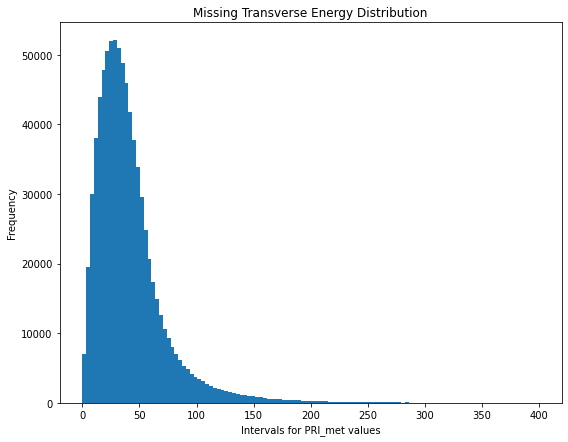

In [19]:
plt.figure(figsize = (9,7))
dfall.PRI_met.plot.hist(bins=np.linspace(0,400,120),title="Missing Transverse Energy Distribution")     #np.linspace(start=first_edge, stop=last_edge,num=n_equal_bins + 1, endpoint=True)
plt.xlabel("Intervals for PRI_met values")


Notice that the Histogram for PRI_met is continuous.

### Histogram for missing transverse energy in case of large leptons 

Text(0.5, 0, 'Intervals for PRI_met values')

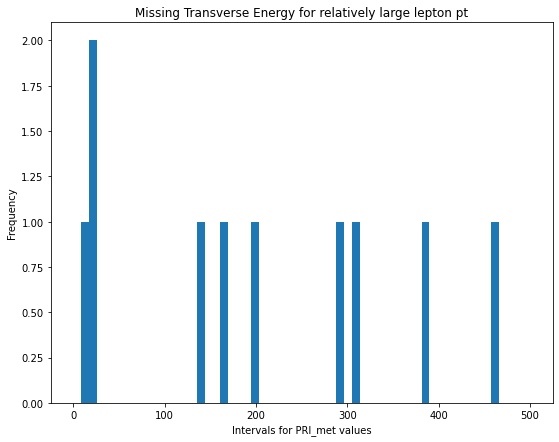

In [20]:
plt.figure(figsize = (9,7))
dfall[dfall.PRI_lep_pt>500]['PRI_met'].plot.hist(bins=np.linspace(0,500,60),title="Missing Transverse Energy for relatively large lepton pt")
plt.xlabel("Intervals for PRI_met values")


You will notice that the graph is discrete 

### Histogram for The transverse mass between the missing transverse energy  and the large leptons

Text(0.5, 0, 'Intervals for DER_mass_transverse_met_lep values')

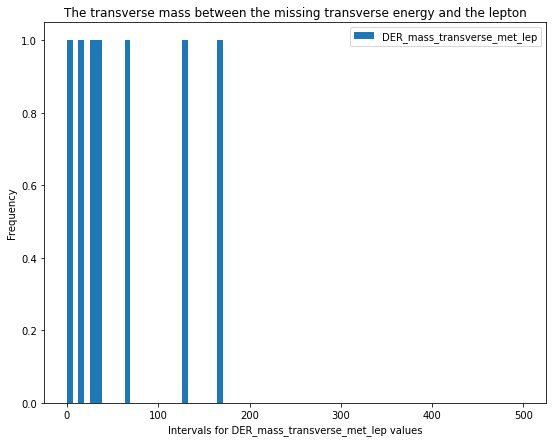

In [21]:
plt.figure(figsize = (9,7))
dfall[dfall.PRI_lep_pt>500]['DER_mass_transverse_met_lep'].plot.hist(bins=np.linspace(0,500,80),legend = "DER_mass_transverse_met_lep" ,title="The transverse mass between the missing transverse energy and the lepton")
plt.xlabel("Intervals for DER_mass_transverse_met_lep values")


### Scatter Plot for ( Signal vs. Background) distribution for some features 

We will create a scatter plot between (PRI_met) and (PRI_lep_pt) showing the difference in distribution for data in case of signal and background 

Text(0, 0.5, 'The Transverse Momentum of the Lepton  (PRI_Lep_pt)')

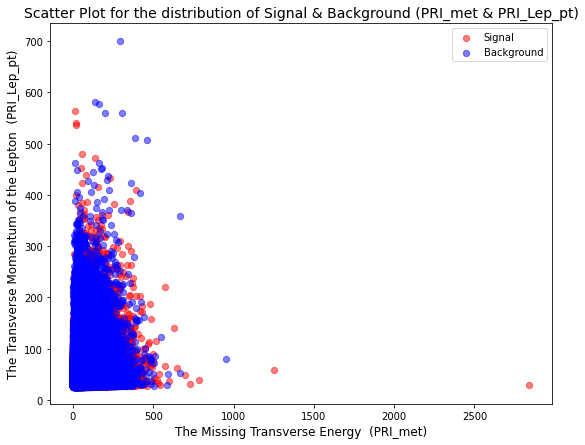

In [22]:
fig = plt.figure(figsize = (9,7))
ax = fig.add_subplot(111)
ax.scatter(dfall[target == 's']['PRI_met'], dfall[target == 's']['PRI_lep_pt'], s=39, color="red", alpha=0.5, label = "Signal")
ax.scatter(dfall[target == 'b']['PRI_met'], dfall[target == 'b']['PRI_lep_pt'], s=39, color="blue", alpha=0.5,label = "Background")
plt.legend()
plt.title("Scatter Plot for the distribution of Signal & Background (PRI_met & PRI_Lep_pt)",fontsize = 14)
plt.xlabel('The Missing Transverse Energy  (PRI_met)', fontsize=12)
plt.ylabel('The Transverse Momentum of the Lepton  (PRI_Lep_pt)',fontsize=12)

### Histogram for the weights for both Signal and Background 

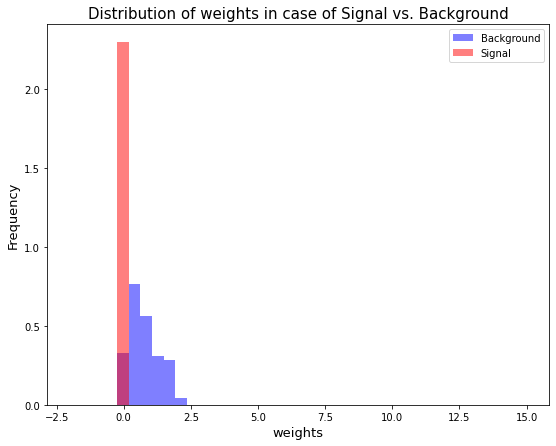

In [23]:
#fig,  ax = plt.subplots()
bins = np.linspace(-2,15,40)
plt.figure(figsize = (9,7))
plt.hist(weights[target == "b"], bins = bins,color = 'b', alpha = 0.5 , density = True, label = 'Background')
plt.hist(weights[target == "s"], bins = bins , color = 'r' , alpha = 0.5 , density = True, label = 'Signal')
plt.legend(loc = 'best')
plt.xlabel('weights', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of weights in case of Signal vs. Background', fontsize=15)
plt.show()
#density because pdf, which means the area under is 1

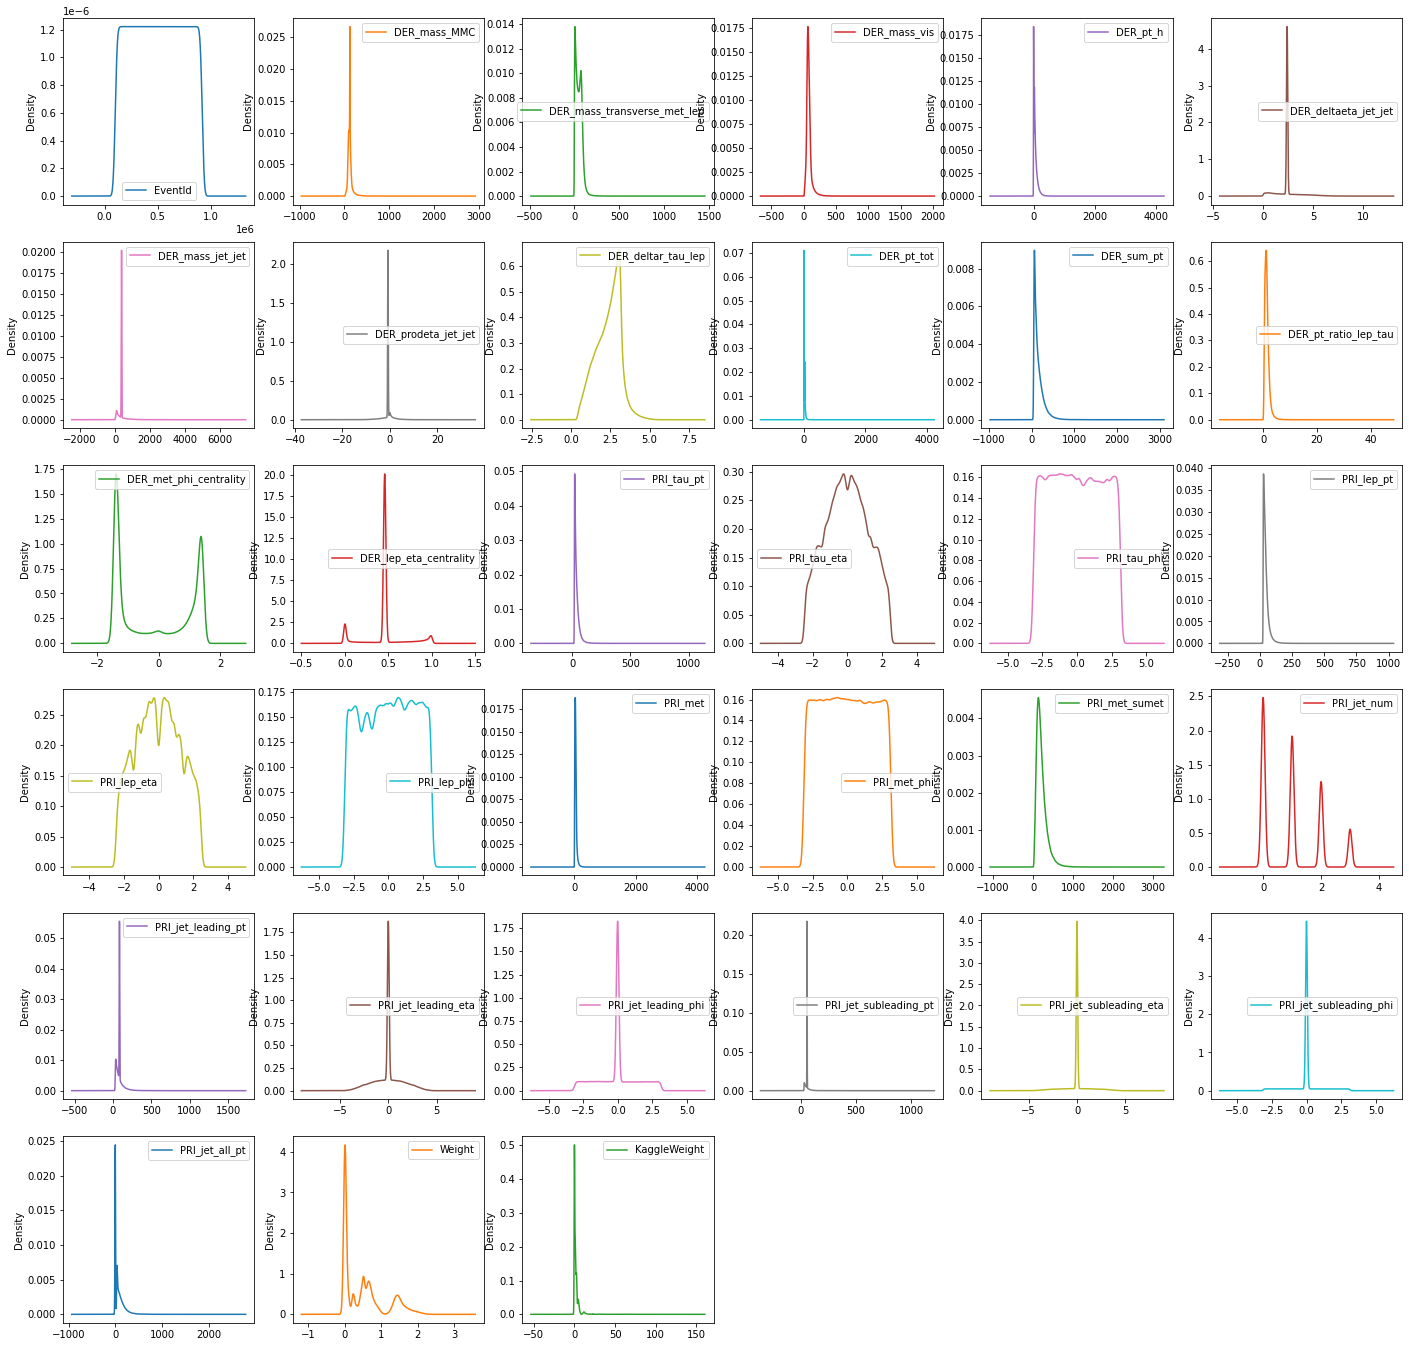

In [24]:
# Becareful this code takes a lot of time 
dfall.plot(kind='density', subplots=True, layout=(6,6), sharex=False, figsize = (24,24))
plt.show()

$s = \sum w$ \\
for signal dataset : predicted number of signal events (luminosity, cross section, efficiencies etc... already included in the weights). Ditto for b background.

Effective number of events fraction :
$$\frac{N_{eff}}{N}= \frac{1}{1+\frac{Var(w)}{<w>^2}}$$ \\
Example : if $0.2$ it means the precision achieved with this dataset is the one which would be achieved with an unweighted dataset of $0.2 \times N$ events (this is a rough estimate, only true for a simple counting)

In other words, less events from unweighted data will give the same results as this weighted data gave.

### Create a new numerical column for Labels

We will denote Signal by 1 and Background by 0

In [25]:
dfall['Label_N'] = np.where(dfall['Label']=='s', 1,0)    # Here you put the statement if true then give the value 1 if false then give the alue 0
dfall.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight,Label_N
0,238233,110.776,9.816,60.117,163.255,5.209000,1131.34600,-6.14800,1.436,13.178,270.273,1.470,1.129,1.00000,37.582,0.684,-0.202,55.256,0.851,-1.628,95.581,-1.493,311.727,2,117.365000,-1.808000,2.008000,60.070000,3.401000,1.21300,177.435,0.000461,s,t,0.001503,1
1,303463,89.278,32.006,68.869,0.245,2.404626,372.18105,-0.82874,2.869,0.245,64.833,1.036,-1.414,0.45848,31.836,-1.502,1.450,32.996,-0.710,-1.308,12.197,3.128,105.755,0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000,0.005721,s,t,0.018636,1
2,749924,107.597,69.753,72.959,18.621,2.404626,372.18105,-0.82874,2.877,18.621,72.634,1.661,0.925,0.45848,27.297,-1.539,-1.578,45.336,-2.169,1.898,27.494,-1.556,171.780,0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000,0.512740,b,v,0.932279,0
3,660576,123.369,31.600,80.724,23.200,2.404626,372.18105,-0.82874,3.024,23.200,83.809,0.545,-1.413,0.45848,54.239,2.041,0.330,29.570,2.322,-2.681,33.035,2.542,127.435,0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000,0.005721,s,v,0.010415,1
4,789596,121.775,16.688,64.226,49.821,5.352000,605.68100,-7.12400,2.913,21.609,147.900,0.867,-1.290,0.73600,33.985,2.098,-1.476,29.466,1.671,1.405,55.980,1.819,224.669,2,49.049000,2.865000,-2.502000,35.399000,-2.486000,-0.81900,84.448,0.000461,s,v,0.000840,1


### Weights calculations for Signal and Background

In [26]:
number_weights = np.zeros(2)
sum_weights = np.zeros(2)
mean_weights = np.zeros(2)
std_weights = np.zeros(2)
Neff_fraction = np.zeros(2)

for i in range(2):
  number_weights[i] = weights[dfall['Label_N']==i].size
  sum_weights[i] = weights[dfall['Label_N']==i].sum()
  mean_weights[i] = weights[dfall['Label_N']==i].mean()
  std_weights[i] = weights[dfall['Label_N']==i].std()
  Neff_fraction[i] = 1/(1 + (std_weights[i]/mean_weights[i])**2)

print("Weights quantities for [ Background (target = 0) , Signal (target = 1)]")
print("weights sum", sum_weights)
print("number of events for each label", number_weights)
print("weights mean", mean_weights)
print("weights std", std_weights)
print("Weights Neff fraction", Neff_fraction)

Weights quantities for [ Background (target = 0) , Signal (target = 1)]
weights sum [410999.84732181    691.98860771]
number of events for each label [538678. 279560.]
weights mean [0.76297871 0.00247528]
weights std [0.54746963 0.0025262 ]
Weights Neff fraction [0.66012388 0.48981936]


### Derived features data distribution for Signal and Background

The Blue color represents Background 
The Green color represents Signal


<Figure size 432x288 with 0 Axes>

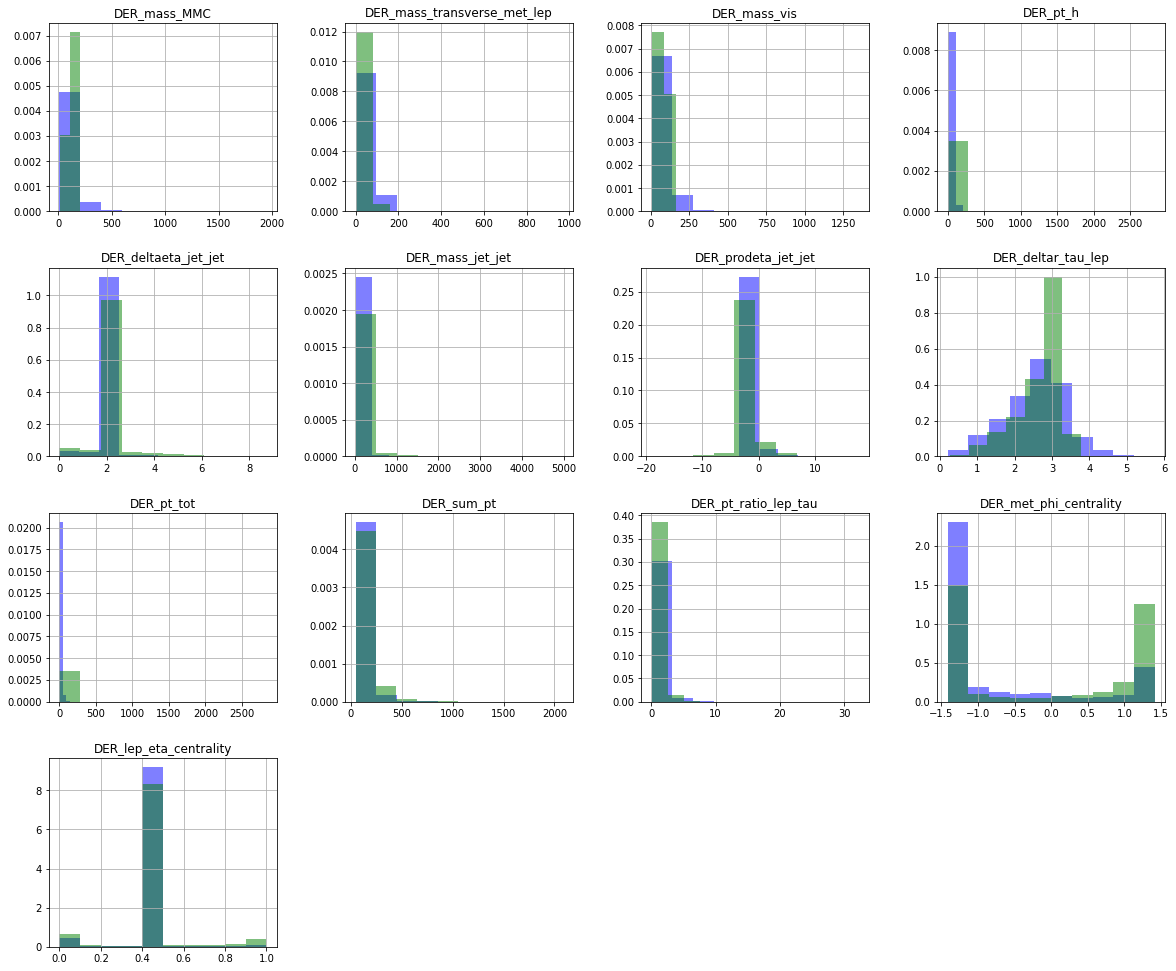

In [27]:
Target = dfall['Label_N']
DER_features = dfall[['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality']]

#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, labels=["S","B"])

print("The Blue color represents Background ")
print("The Green color represents Signal")
plt.figure()

ax=DER_features[Target==0].hist(weights=weights[Target==0],figsize=(20,17),color='b',alpha=0.5,density=True,label="B")
ax=ax.flatten()[:DER_features.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
DER_features[Target==1].hist(weights=weights[Target==1],figsize=(20,17),color='g',alpha=0.5,density=True,ax=ax,label="S")

plt.legend([ax],loc='best')
plt.show()

### Primitive features Data distribution for Signal & Background

The Blue color represents Background 
The Green color represents Signal


<Figure size 432x288 with 0 Axes>

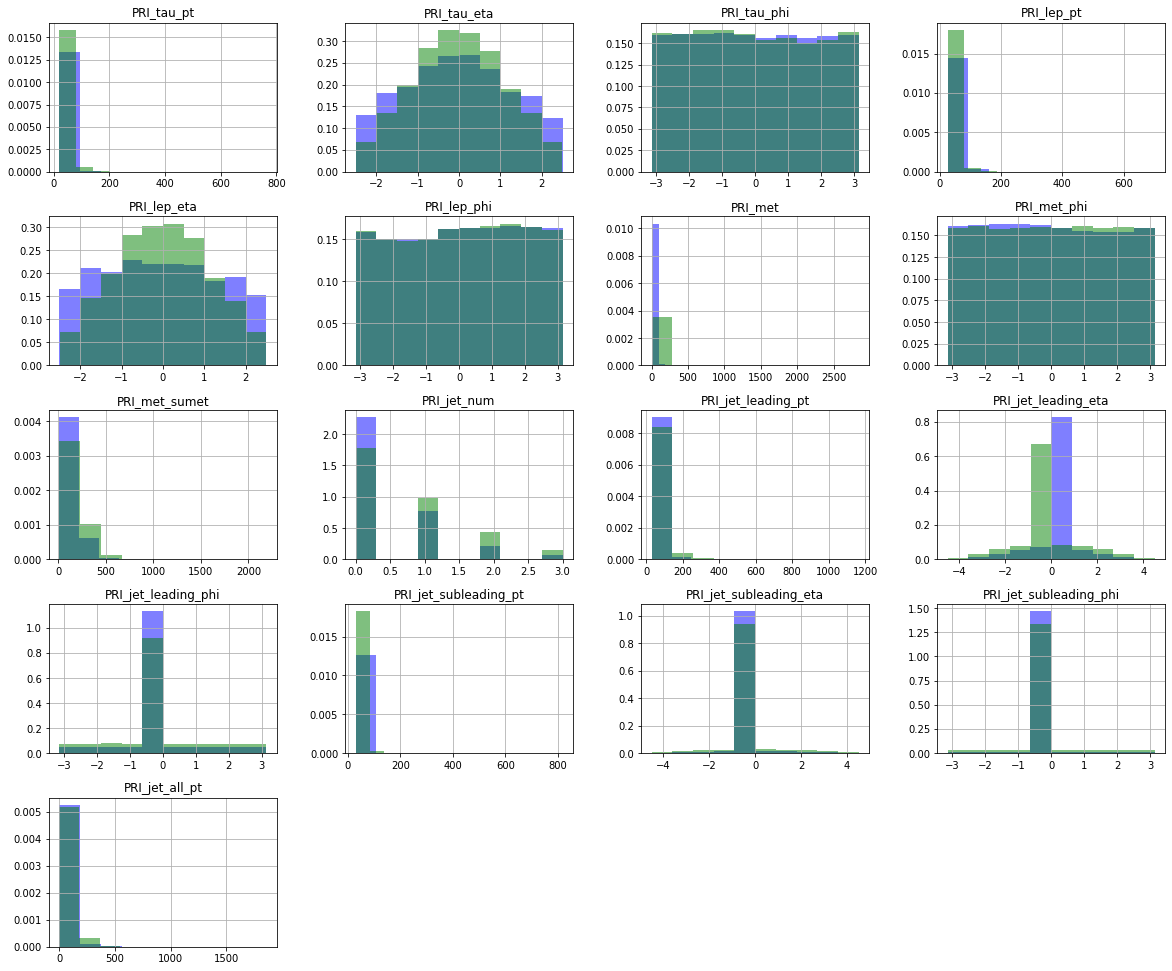

In [28]:
PRI_features = dfall[['PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']]

print("The Blue color represents Background ")
print("The Green color represents Signal")
plt.figure()

ax=PRI_features[Target==0].hist(weights=weights[Target==0],figsize=(20,17),color='b',alpha=0.5,density=True,label="B")
ax=ax.flatten()[:PRI_features.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
PRI_features[Target==1].hist(weights=weights[Target==1],figsize=(20,17),color='g',alpha=0.5,density=True,ax=ax,label="S")


plt.legend([ax],loc='best')
plt.show()


### Heatmap for Background events only

A heatmap is a graphical representation of data that uses a system of color-coding to represent different values. 
Check the following link for Heatmap using Seaborn library:  https://seaborn.pydata.org/generated/seaborn.heatmap.html

We will create a heatmap to show the correlation between features only for the events which have Background label

Background features correlation matrix


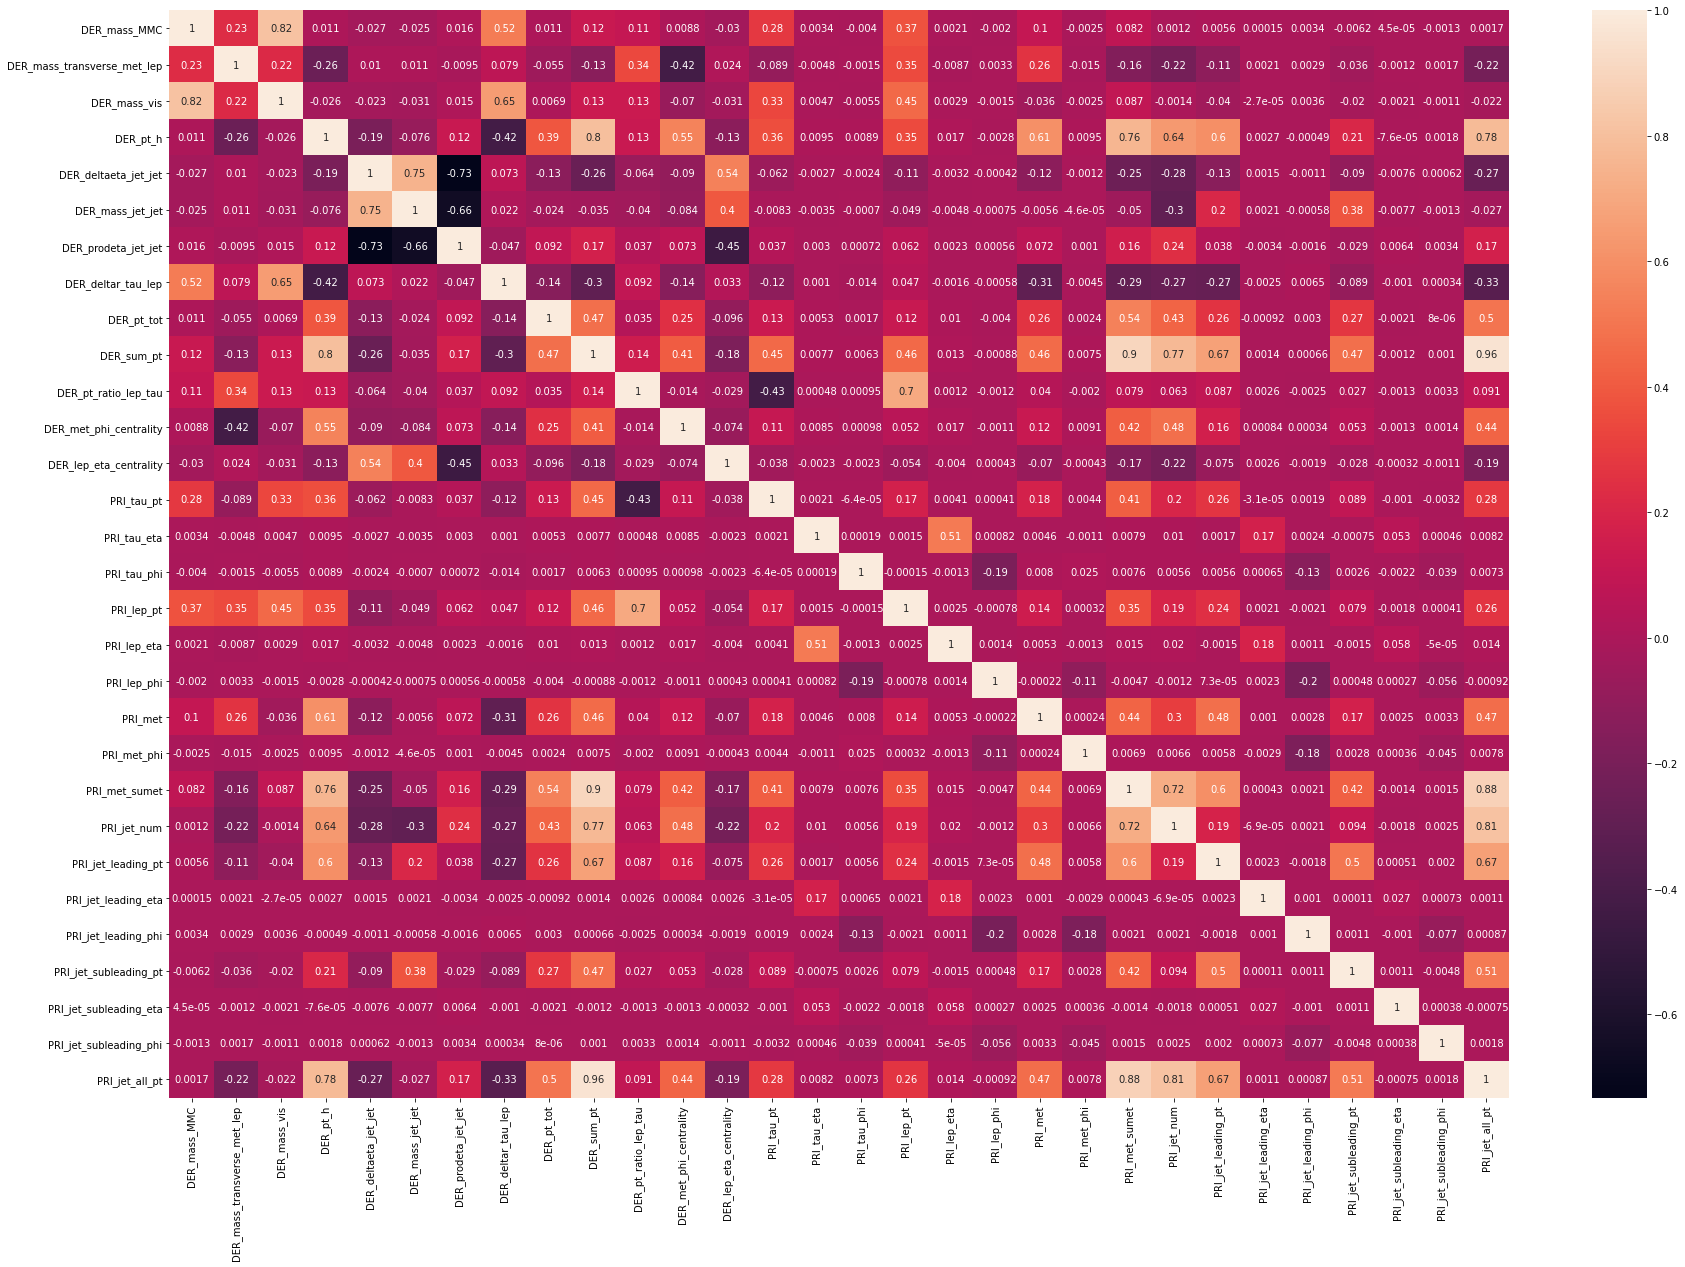

In [29]:
DER_and_PRI  = dfall[['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']]

import seaborn as sn # seaborn for nice plot quicker
print ("Background features correlation matrix")
corrMatrix = DER_and_PRI[Target==0].corr()
plt.figure(figsize = (30,20))
sn.heatmap(corrMatrix, annot=True)
plt.show()



### Heatmap for Singal events

Signal feature correlation matrix


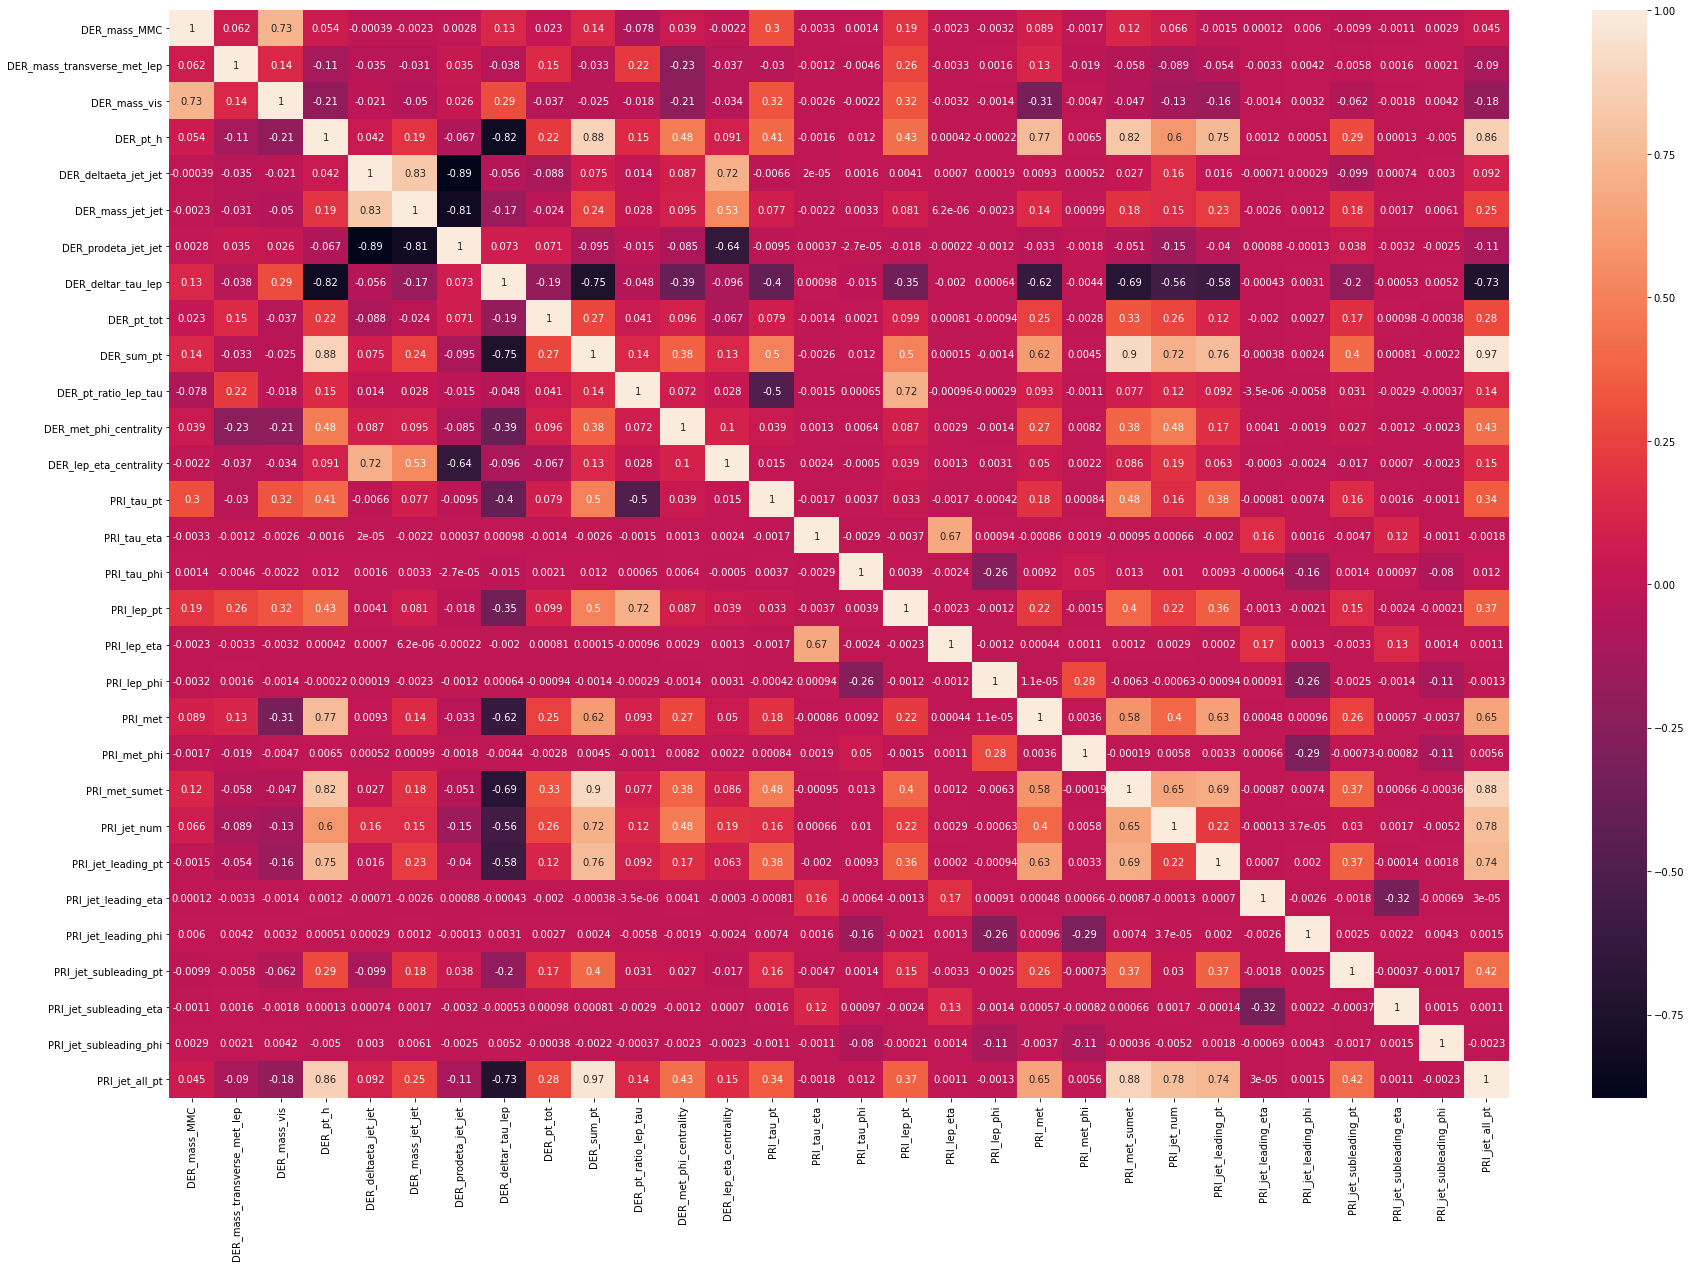

In [30]:
print ("Signal feature correlation matrix")
corrMatrix = DER_and_PRI[Target==1].corr()
plt.figure(figsize = (30,20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Data splitting for traning and testing (for PRI & DER) 

We will use the small Dataframe which contains only the Derived and Primitive Features (30 features) 

### Data Splitting

We will define:

1) X_train: which is the portion of events taken from the dataframe containing the 30 feature which we will train our model with. \
2) X_test: the left events and features in the dataframe which we will test our model with them to see how good our model is. \
3) y_train: the labels for events in X_train.\
4) y_test: Labels for events in X_test.\
5) weights_train: the respective weights for events in X_train.\
6) weights_test: the weights for events in X_test.

In [31]:
#np.random.seed(31415) # set the random seed (used for the train/test splitting)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.61106915102 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(DER_and_PRI, Target, weights, train_size=train_size, random_state = 31415)  # add random state instead of random seed
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

print ("Dimensions for <<training>> events:",X_train.shape)
print ("Number of Labels for <<training>> events",y_train.shape)
print ("Number of Weights for <<training>> events",weights_train.shape)
print ("Dimensions for <<testing>> events:",X_test.shape)
print ("Number of Labels for <<testing>> events:",y_test.shape)
print ("Number of Weights for <<testing>> events:",weights_test.shape)



Dimensions for <<training>> events: (499999, 30)
Number of Labels for <<training>> events (499999,)
Number of Weights for <<training>> events (499999,)
Dimensions for <<testing>> events: (318239, 30)
Number of Labels for <<testing>> events: (318239,)
Number of Weights for <<testing>> events: (318239,)


### Rescaling the Variables

The following process is not important for XGBoost model, but very important for Neural Networks.

In [32]:
#scale to mean 0 and variance 1

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())

for i in range(len(class_weights_train)):
    #training dataset: equalize number of background and signal
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] 
    #test dataset : increase test weight to compensate for sampling
    weights_test[y_test == i] *= 1/(1-train_size) 
    
print ("Orig : total weight sig", weights[Target == 1].sum())
print ("Orig : total weight bkg", weights[Target == 0].sum())
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())

#important for the dataset to be balanced for NN 

Orig : total weight sig 691.9886077119883
Orig : total weight bkg 410999.84732181125
Test : total weight sig 691.678608328453
Test : total weight bkg 410235.35640394705
Train : total weight sig 251446.6618740111
Train : total weight bkg 251446.6618740111


### Defining the Significance Function

As mentioned in the opendata site The evaluation metric is the approximate median significance (AMS)

In [33]:
from math import sqrt
from math import log
def amsasimov(s,b): # asimov significance arXiv:1007.1727 eq. 97  + footnote 
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

## Applying the Boosted Decision Trees Model

### Running XGBoost with default Parameters

In [34]:
#np.random.seed(31415) # set the random seed  useful?  try checking without 

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
# tree_method="hist" is 10 times faster, however less robust against awkwards features (not a bad idea to double check without it)
# can even try tree_method="gpu_hist" if proper GPU installation
# use_label_encoder and eval_metric to silence warning in 1.3.0
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',random_state = 31415)
# HPO (==Hyper Parameter Optimization), check on the web https://xgboost.readthedocs.io/ for other parameters
#xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,max_depth=10,n_estimators=100) 



starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values) # note that XGB 1.3.X requires positive weight

        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))
int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
significance_xgb = max(vamsasimov_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")


Training time: 12.697853565216064
auc test: 0.934684060582711
auc train: 0.9113366020869034
Z: 3.728232875269696


### Finding the best parameters

The Parameters are: 

1) n_estimators \
2) max_depth \
3) learning_rate

In [35]:

#RandomSearchCV for advanced HPO 
import scipy.stats as stats
#if False:
from sklearn.model_selection import RandomizedSearchCV

# specify parameters and distributions to sample from
param_dist_XGB = {'max_depth': stats.randint(2, 10), # default 6
                  'n_estimators': stats.randint(10, 500), #default 100
                  'learning_rate': stats.uniform(0.1, 0.5)} #def 0.3 

# default CV is 5 fold, reduce to 2 for speed concern
gsearch = RandomizedSearchCV(estimator = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss'), 
                    param_distributions = param_dist_XGB, 
                    scoring='roc_auc',n_iter=10,cv=2,  random_state = 31415)  #it may give an error 
gsearch.fit(X_train,y_train, sample_weight=weights_train)

print ("Best parameters : ",gsearch.best_params_)
print ("Best score (on train dataset CV) : ",gsearch.best_score_)


y_pred_gs = gsearch.predict_proba(X_test)[:,1]
print("... corresponding score on test dataset : ",roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test))
dfsearch=pd.DataFrame.from_dict(gsearch.cv_results_)
display(dfsearch)


Best parameters :  {'learning_rate': 0.11773499858335287, 'max_depth': 8, 'n_estimators': 99}
Best score (on train dataset CV) :  0.9011286590688941
... corresponding score on test dataset :  0.9353497143292868


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,2.229838,0.025763,0.270941,0.005493,0.422909,5,23,"{'learning_rate': 0.42290930295437734, 'max_de...",0.892728,0.893623,0.893176,0.000447,7
1,17.400112,0.030196,1.219203,0.004800,0.585352,4,400,"{'learning_rate': 0.5853519930243356, 'max_dep...",0.894308,0.893667,0.893987,0.000320,6
2,31.829900,0.135239,2.628335,0.008892,0.554533,8,351,"{'learning_rate': 0.554532921359051, 'max_dept...",0.887315,0.886835,0.887075,0.000240,10
3,4.854816,0.011391,0.332506,0.000862,0.343355,2,122,"{'learning_rate': 0.3433548604919223, 'max_dep...",0.889008,0.890990,0.889999,0.000991,9
4,7.205486,0.104488,0.633031,0.004716,0.421756,8,68,"{'learning_rate': 0.42175623156735187, 'max_de...",0.896387,0.896109,0.896248,0.000139,5
5,5.062919,0.024619,0.337603,0.002474,0.53761,2,127,"{'learning_rate': 0.5376095557371947, 'max_dep...",0.892461,0.893360,0.892910,0.000449,8
6,10.119197,0.054805,0.852462,0.000625,0.15335,6,148,"{'learning_rate': 0.1533499951503625, 'max_dep...",0.900538,0.900708,0.900623,0.000085,2
7,10.904528,0.154795,0.845708,0.008292,0.117735,8,99,"{'learning_rate': 0.11773499858335287, 'max_de...",0.900989,0.901269,0.901129,0.000140,1
8,17.005918,0.053763,1.217191,0.012555,0.408722,4,396,"{'learning_rate': 0.4087223520047091, 'max_dep...",0.897697,0.898389,0.898043,0.000346,4
9,15.055160,0.110387,1.067352,0.003523,0.270076,4,339,"{'learning_rate': 0.2700761355646528, 'max_dep...",0.900065,0.899796,0.899931,0.000134,3


The above Dataframe tells you the values for the parameters and the scores respectively and it ranks them, the best parameter is for rank 1

### mean_test_score for different values of parameters

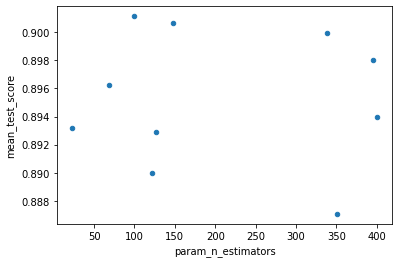

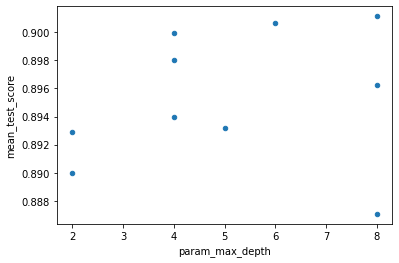

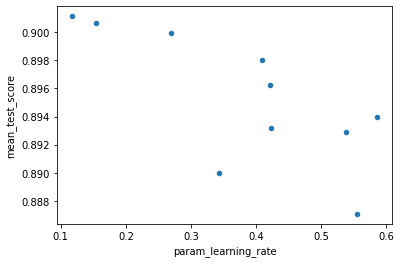

In [36]:
dfsearch.plot.scatter("param_n_estimators","mean_test_score")
dfsearch.plot.scatter("param_max_depth","mean_test_score")
dfsearch.plot.scatter("param_learning_rate","mean_test_score")

## Learning Curve 

Compute the AUC and Significance by varying the number of training event. 

### Accuracy and Significance for Different Training Sizes

In [37]:

#In principle could, use learning_curve in sklearn
#However : it does not handle weights, it does not allow to control testing dataset size
#from sklearn.model_selection import learning_curve
#train_sizes,train_scores,test_scores=learning_curve(
#     XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',n_estimators=10),
#     X_train,y_train,
#     train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1],                  
#     scoring='roc_auc',cv=5)


train_sizes=[0.01,0.05,0.1,0.2,0.5,0.75,1]
ntrains=[]
test_aucs=[]
train_aucs=[]
times=[]
z = []

for train_size in train_sizes:
  ntrain=int(len(X_train)*train_size)
  print("training with ",ntrain," events")
  ntrains+=[ntrain]
  starting_time = time.time()

  # train using the first ntrain event of the training dataset
  xgb.fit(X_train[:ntrain,], y_train[:ntrain], sample_weight=weights_train[:ntrain])
  training_time = time.time( ) - starting_time
  times+=[training_time]

  # score on test dataset (always the same)
  y_pred_xgb=xgb.predict_proba(X_test)[:,1]
  auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test)
  test_aucs+=[auc_test_xgb]

  # score on the train dataset 
  y_train_xgb=xgb.predict_proba(X_train[:ntrain])[:,1]
  auc_train_xgb = roc_auc_score(y_true=y_train[:ntrain], y_score=y_train_xgb,sample_weight=weights_train[:ntrain])
  train_aucs+=[auc_train_xgb]
  
  int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
  vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
  significance_xgb = max(vamsasimov_xgb)
  Z = significance_xgb
  z+=[Z]

dflearning = pd.DataFrame({"Ntraining":ntrains,
                         "test_auc":test_aucs,
                         "train_auc":train_aucs,
                         "time":times,
                         "Significance": z})
display(dflearning)

training with  4999  events
training with  24999  events
training with  49999  events
training with  99999  events
training with  249999  events
training with  374999  events
training with  499999  events


,Ntraining,test_auc,train_auc,time,Significance
0,4999,0.907987,0.999718,0.814368,2.879597
1,24999,0.920455,0.991517,1.594293,3.093181
2,49999,0.925125,0.981486,2.295171,3.268988
3,99999,0.928957,0.968979,3.518936,3.447016
4,249999,0.932692,0.954081,6.980632,3.630338
5,374999,0.934031,0.949219,9.888487,3.707544
6,499999,0.934684,0.947221,12.780989,3.728233


Text(0.5, 1.0, 'Training and Testing AUC values for different Training Size')

<Figure size 504x648 with 0 Axes>

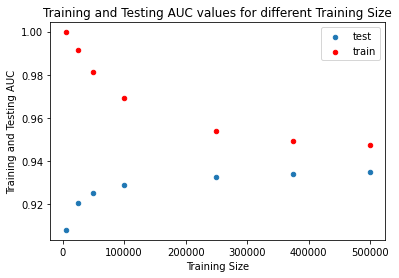

In [38]:
plt.figure(figsize=(7,9))
ax=dflearning.plot.scatter("Ntraining","test_auc",label="test")
dflearning.plot.scatter("Ntraining","train_auc",label="train",color="r",ax=ax)
plt.xlabel("Training Size")
plt.ylabel("Training and Testing AUC")
plt.title("Training and Testing AUC values for different Training Size")

### Adding the Parameters from RandomizedSearchCV

In [39]:
 
xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss', learning_rate = 0.11773499858335287 , max_depth = 8 , n_estimators = 99, random_state = 31415)


starting_time = time.time()

xgb.fit(X_train, y_train.values, sample_weight=weights_train.values) # note that XGB 1.3.X requires positive weight

        
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb_more_paramters = xgb.predict_proba(X_test)[:,1]
y_pred_xgb_more_paramters = y_pred_xgb_more_paramters.ravel()
y_pred_train_xgb_more_paramters = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb_more_paramters = roc_auc_score(y_true=y_test, y_score=y_pred_xgb_more_paramters,sample_weight=weights_test)
print("auc test:",auc_test_xgb_more_paramters)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb_more_paramters,))
int_pred_test_sig_xgb_more_paramters = [weights_test[(y_test ==1) & (y_pred_xgb_more_paramters > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb_more_paramters = [weights_test[(y_test ==0) & (y_pred_xgb_more_paramters > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb_more_paramters = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb_more_paramters,int_pred_test_bkg_xgb_more_paramters)]
significance_xgb_more_paramters = max(vamsasimov_xgb_more_paramters)
T = significance_xgb_more_paramters
print("Z:",T)

Training time: 18.451905488967896
auc test: 0.9353497143292868
auc train: 0.9141249610130802
Z: 3.7255006534710566


## Applying Lightgbm Model

In [40]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
#gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier(random_state = 31415)
# gbm = lgb.LGBMClassifier(max_depth=12) # HPO, check on the web https://lightgbm.readthedocs.io/ for other parameters


starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)
#gbm.fit(X_train, y_train.values) #ma


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm, sample_weight = weights_test)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))

int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
W = significance_gbm
print("Z:",W)
# To save model
gbm.booster_.save_model("LightGBM.model")

Training time: 12.960000991821289
auc test: 0.9345710477599068
auc train: 0.9004526306055679
Z: 3.644266069463598


### Comparing between XGBoost and LightGBM with default Parameters

In [41]:
print('Best significance found are:')
print('LightGBM: ', W)
print('XGBoost : ', Z)
print('Best auc test found are:')
print('LightGBM: ', auc_test_gbm)
print('XGBoost: ', auc_test_xgb)

Best significance found are:
LightGBM:  3.644266069463598
XGBoost :  3.728232875269696
Best auc test found are:
LightGBM:  0.9345710477599068
XGBoost:  0.934684060582711


## Load Score Plotting Function 

### Define Compare_train_test Function

We will define a function to compare between the labels of X_train taken from y_train vs. the predicted Labels for the X_train which either XGB or LightGBM will predict and between the labels from y_test which are the true labels of X_test vs. the predicted labels for X_test using one of those two models 

In [42]:
from math import sqrt
from math import log 


# Plot score for signal and background, comparing training and testing
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), bins=30, xlabel="", ylabel="Arbitrary units", title="", weights_train=np.array([]), weights_test=np.array([])):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=True,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=True,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=True, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=True, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
  

### Apply the Comparing Function on the Two Models

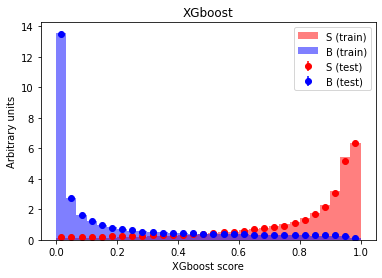

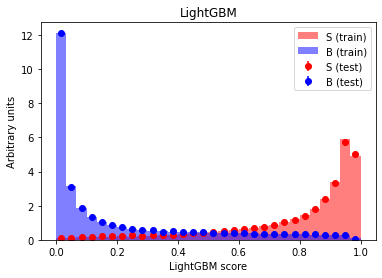

In [43]:
compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, xlabel="XGboost score", title="XGboost", weights_train=weights_train.values, weights_test=weights_test.values)
#plt.savefig("Score_BDT_XGBoost_Hist.pdf")
plt.show()
compare_train_test(y_pred_train_gbm, y_train, y_pred_gbm, y_test, xlabel="LightGBM score", title="LightGBM", weights_train=weights_train.values, weights_test=weights_test.values)
#plt.savefig("Score_BDT_LightGBM.pdf")
plt.show()

### Historam for the Data Distribution of y_pred_xgb for Signal vs. Background

Note that the values of y_pred_xgb are normalized to values in the interval $[0,1]$ so they are P.D.F. (Probability Density Function) so the area under each Histogram is $1$

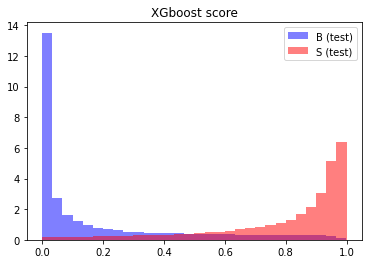

In [44]:
density=True   # normalised to 1 (=> probability density function)
#density=False   # normalised to one year at LHC  

_ = plt.hist(y_pred_xgb[y_test == 0],
                 color='b', alpha=0.5, 
                #range=high_low, 
                bins=30,
                 histtype='stepfilled', density=density,
                 label='B (test)', weights=weights_test[y_test == 0]) # alpha is transparancy
_ = plt.hist(y_pred_xgb[y_test == 1],
                 color='r', alpha=0.5, 
                #range=high_low, 
                bins=30,
                 histtype='stepfilled', density=density,
                 label='S (test)', weights=weights_test[y_test == 1]) # alpha is transparancy
plt.legend()
_ = plt.title ("XGboost score")
#                 color='b', alpha=0.5, range=high_low, bins=bins,
#                 histtype='stepfilled', density=True,
#                 label='B (train)', weights=weights_test_background)

## ROC Curve 

### ROC Curve for each Model & AUC 

ROC curve plots TPR vs. FPR at different classification thresholds, Check the following website for helpful info about it.

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

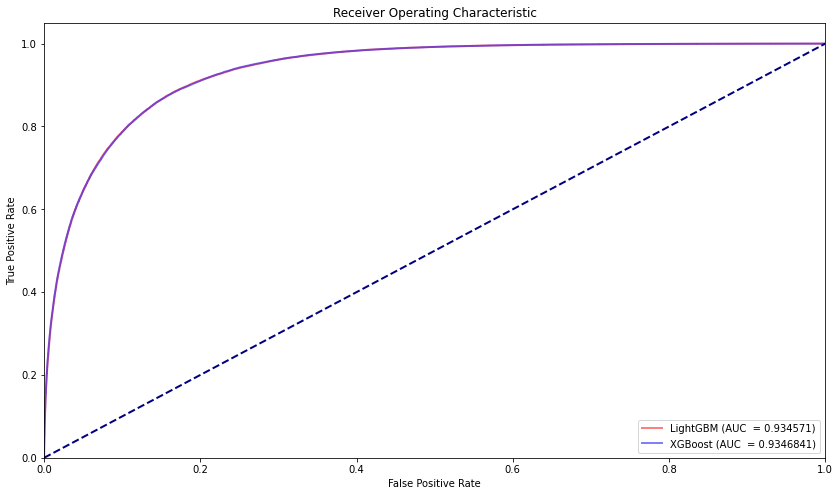

In [45]:

from sklearn.metrics import roc_curve
lw = 2
plt.figure(figsize = (14,8))
fpr_gbm,tpr_gbm,_ = roc_curve(y_true=y_test, y_score=y_pred_gbm,sample_weight=weights_test.values)
fpr_xgb,tpr_xgb,_ = roc_curve(y_true=y_test, y_score=y_pred_xgb,sample_weight=weights_test.values)
plt.plot(fpr_gbm, tpr_gbm, color='red',lw=lw, alpha = 0.5, label='LightGBM (AUC  = {})'.format(np.round(auc_test_gbm,decimals=7)))
plt.plot(fpr_xgb, tpr_xgb, color='blue',lw=lw,alpha = 0.5,  label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=7)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#import os
#new_dir = "Plots/Comparing" 
#if not os.path.isdir(new_dir):
#    os.mkdir(new_dir)
#plt.savefig("ROC_comparing.pdf")
plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate

Notice how the two curves are roughly the same, and the area under are very similar, so how we will tell which model is better? 

### Significance at Different Thresholds

As mentioned the main criteria to say how good our model is, will be significance, so we will plot the different values of significance according to their respective threshold, then we will see which model gives the highest significance 

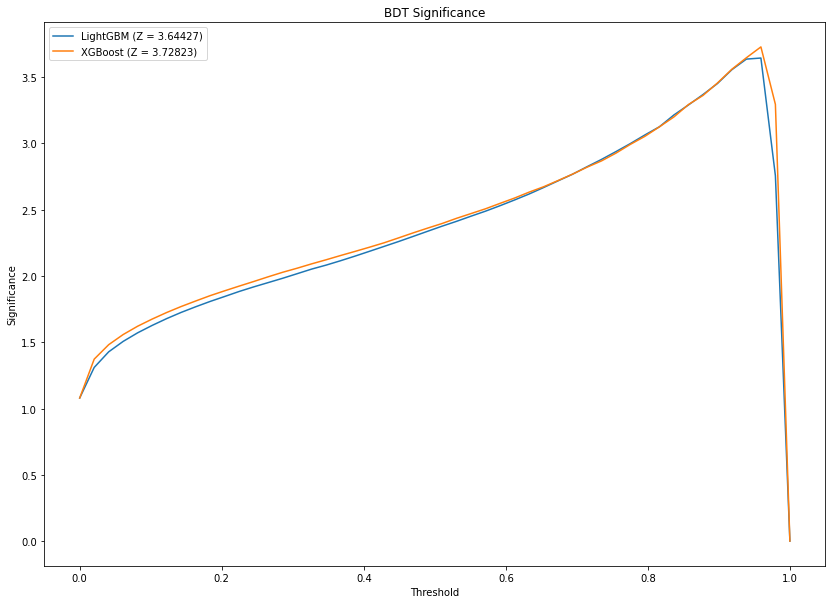

In [46]:
plt.figure(figsize = (14,10))
plt.plot(np.linspace(0,1,num=50),vamsasimov_gbm, label='LightGBM (Z = {})'.format(np.round(significance_gbm,decimals=5)))
plt.plot(np.linspace(0,1,num=50),vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb,decimals=5)))

plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_comparing.pdf")
plt.show()

So, XGBoost gave the highest significance !

## Model Serialisation


In [47]:
import joblib
myxgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',n_estimators=5)
myxgb.fit(X_train, y_train, sample_weight=weights_train)

auc_test_xgb = roc_auc_score(y_true=y_test, y_score=myxgb.predict_proba(X_test)[:,1],sample_weight=weights_test)
joblib.dump(myxgb, "myxgb.dat")

print ("myxgb score",auc_test_xgb)

del myxgb # delete model

myxgb_reloaded=joblib.load("myxgb.dat")
auc_test = roc_auc_score(y_true=y_test, y_score=myxgb_reloaded.predict_proba(X_test)[:,1],sample_weight=weights_test)

print ("myxgb reloaded score",auc_test)

myxgb score 0.9204900624895211
myxgb reloaded score 0.9204900624895211


## Feature importance:


### Using plt.bar:

We will display the imprortance of each feature without rerunning the whole training process, however it can't be used as a reliable indication of which feature is the most discriminant.

Check the following Link for explanation: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

#### For XGBoost:

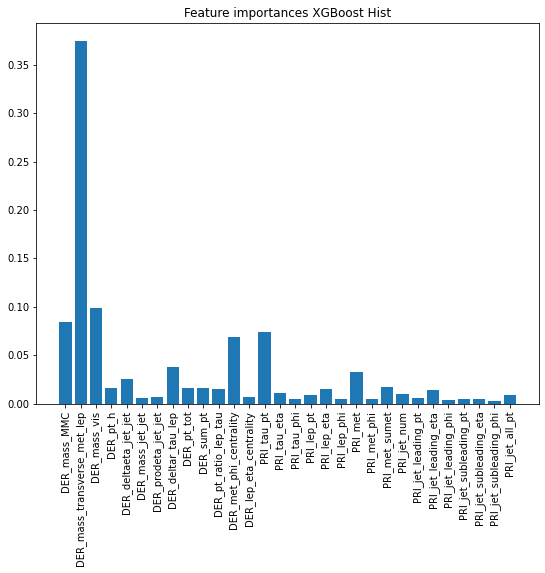

In [48]:
plt.figure(figsize=(9,7))
plt.bar(DER_and_PRI.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")
#plt.savefig(new_dir + "/VarImp_BDT_XGBoost_Hist.pdf",bbox_inches='tight')
plt.show()
#check what y-wxis represent

#### For LightGBM:

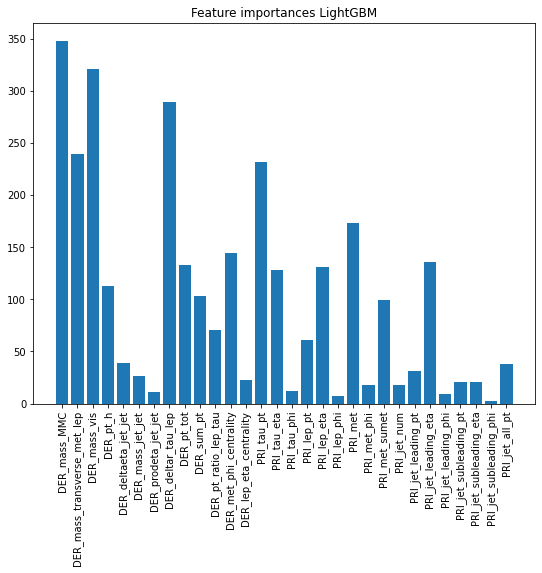

In [49]:
plt.figure(figsize=(9,7))
plt.bar(DER_and_PRI.columns.values, gbm.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances LightGBM")
#plt.savefig(new_dir + "/VarImp_BDT_LightGBM.pdf",bbox_inches='tight')
plt.show()

### Permutation Importance

A better way to show the importance of each feature is Permutation Importance, where each feature in turn is replaced by an instance of an other event (effectively switching it off by randomising). One possible implementation: https://github.com/aghoshpub/permutationImportancePhysics In particular it allows to :

1) it tells how much you lose in significance if this features was not included \
2) display directly the loss in whatever criteria (ROC auc, asimov significance) when the feature is switched off
 \
 3) display the feature importance for a specific subset (for example the most signal like)
 \
 4) it can even display which feature has the larges impact on systematics

However, report can be misleading in case of highly correlated variables.



#### For XGB Model

Displaying the Result:

In [50]:
!pip install PermutationImportancePhysics
from permutationimportancephysics.PermutationImportance import PermulationImportance # note the delibrate typo PermuLation
PI_xgb = PermulationImportance(model=xgb, X=X_test,y=y_test,weights=weights_test,\
                        n_iterations=1,usePredict_poba=True, scoreFunction="amsasimov", colNames=list(DER_and_PRI.columns.values))
PI_xgb.dislayResults()



[['1.4629545142888798' '0.0' '0.0' 'DER_mass_MMC']
 ['1.383035345257977' '0.0' '0.0' 'DER_mass_transverse_met_lep']
 ['1.342909226572432' '0.0' '0.0' 'PRI_tau_pt']
 ['0.5620138720198495' '0.0' '0.0' 'DER_mass_vis']
 ['0.43630573525508254' '0.0' '0.0' 'DER_deltar_tau_lep']
 ['0.195639744295097' '0.0' '0.0' 'DER_sum_pt']
 ['0.17528084797002297' '0.0' '0.0' 'PRI_jet_leading_eta']
 ['0.16676043553992015' '0.0' '0.0' 'PRI_met_sumet']
 ['0.1473394930878169' '0.0' '0.0' 'PRI_lep_eta']
 ['0.14101457332932377' '0.0' '0.0' 'DER_pt_h']
 ['0.1354657068521683' '0.0' '0.0' 'DER_deltaeta_jet_jet']
 ['0.12127796627500897' '0.0' '0.0' 'PRI_met']
 ['0.11518006679081738' '0.0' '0.0' 'DER_met_phi_centrality']
 ['0.10268107521219783' '0.0' '0.0' 'PRI_jet_all_pt']
 ['0.06756008520277934' '0.0' '0.0' 'PRI_tau_eta']
 ['0.049746541453297155' '0.0' '0.0' 'DER_lep_eta_centrality']
 ['0.039472656443560794' '0.0' '0.0' 'PRI_jet_leading_pt']
 ['0.034409383337258515' '0.0' '0.0' 'DER_pt_tot']
 ['0.03116511801141053'

Plotting the values of each bar:

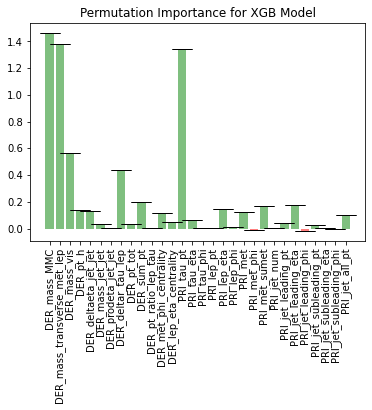

In [51]:
plott_xgb = PI_xgb.plotBars()

plott_xgb.xticks(rotation=90)
plott_xgb.title("Permutation Importance for XGB Model")
plott_xgb.show()


#### For LightGBM Model:

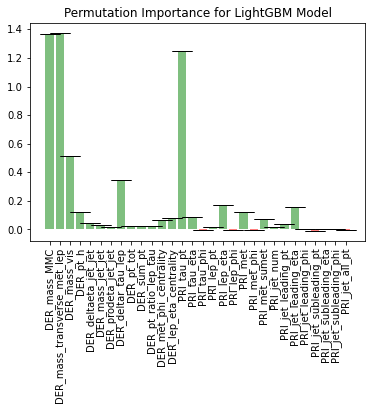

In [52]:
PI_gbm = PermulationImportance(model=gbm, X=X_test,y=y_test,weights=weights_test,\
                        n_iterations=1,usePredict_poba=True, scoreFunction="amsasimov", colNames=list(DER_and_PRI.columns.values))
#PI_gbm.dislayResults()

plott_gbm = PI_gbm.plotBars()

plott_gbm.xticks(rotation=90)
plott_xgb.title("Permutation Importance for LightGBM Model")
plott_gbm.show()

### Extracting Feature Importance with visuals

In [53]:
if False:
  !pip install VPython
  import VPython as vs
  xgb = XGBClassifier(tree_method="hist",use_label_encoder=False,eval_metric='logloss',random_state = 31415)
  model = xgb.fit(X_train, y_train.values, sample_weight=weights_train.values)
  # Extract the feature importances using .feature_importances_ 
  importances = model.feature_importances_
  vs.feature_plot(importances, X_train, y_train)

# This does not work because Visuals Library was modified to VPython, and I have no knowledge about this Library

## Important Links from Prof. David and Recommended Papers:

1) HIggsML challenge data : http://opendata.cern.ch/record/328 : htautau 800k Events

2) Giles Strong study on HiggsML dataset  https://arxiv.org/abs/2002.01427 

3) Historic whiteson paper https://arxiv.org/abs/1410.3469 

4) famous paper with AMS asimov formula equation 98 of : https://arxiv.org/abs/1007.1727 
